In [1]:
import numpy as np             
import sounddevice as sd        #importamos sounddevice paquete para la reproduccion y grabacion de audio 
from scipy.io import wavfile    #modulo para lecto-escritura de archivos .wav
import matplotlib.pyplot as plt
import IPython

In [2]:
from acousticfield.generate import sweep, puretone, whitenoise, pinknoise
from acousticfield.io import play_rec
from acousticfield.process import ir_extract, fadeinout

In [ ]:
sd.query_devices()

In [3]:
sd.default.device = [2,4]

In [ ]:
sweep1 = sweep(T=10.0,fs=48000,f1=30,f2=22000,filename='sweep10s_30_22k')

In [25]:
rec_1 = play_rec('sweep10s_30_22k','rec_L1D1M3') 

listo


In [131]:
ri_1 = ir_extract('rec_L1D1M3','sweep10s_30_22k','ri_1')

<IPython.core.display.Javascript object>


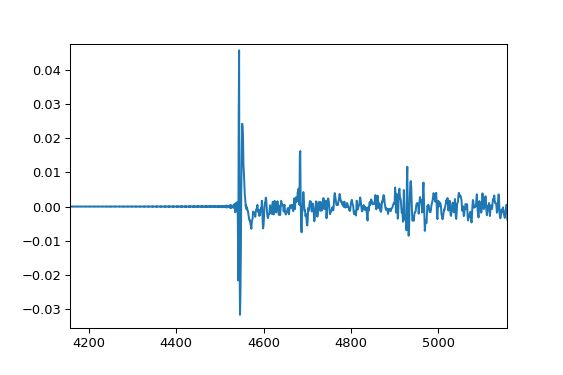

In [132]:
plt.plot(ri_1)

In [16]:
s = whitenoise(2,600)
s = fadeinout(s,0.02)
IPython.display.Audio(s.T,rate=48000)

In [17]:
def fadeio(data, fadein=0.05, fadeout=None, fs=48000):
    if fadein is not None:
        nin = int(2.0*fadein*fs)
        a = (1.0-np.cos(np.linspace(0,np.pi,nin)))/2.0 
        if data.ndim == 2:
            for n in range(data.shape[1]):
                data[:nin,n]  *= a
        else:
            data[:nin] *= a
    if fadeout is not None:
        nout = int(2.0*fadeout*fs)
        a = (1.0+np.cos(np.linspace(0,np.pi,nout)))/2.0 
        if data.ndim == 2:
            for n in range(data.shape[1]):
                data[-nout:,n]  *= a
        else:
            data[-nout:] *= a        

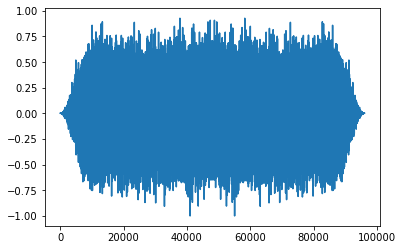

In [22]:
s = whitenoise(2,600)
fadeio(s,0.1,0.1)
plt.plot(s)

In [65]:
def find_dir(data, pw=1.0, fs=48000):
    nw = int(np.floor(pw*fs/1000))
    pmax = np.max(np.abs(data))
    n0 = np.argmax(np.abs(data)>pmax/np.sqrt(10))
    n0=max(n0,nw+1) 
    npk = np.argmax(np.abs(data[n0-nw:n0+nw]))
    nc = n0+npk-nw-2
    n1 = np.maximum(1,int(nc-1.0*nw))
    n2 = int(nc+1.5*nw)
    return [n1,n2]

In [66]:
ndir = find_dir(ri_1,pw=0.5)

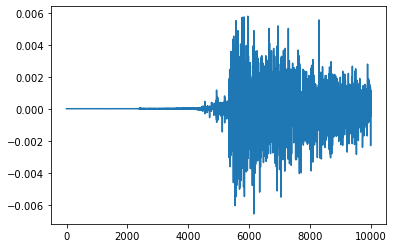

In [101]:
plt.plot(ri_1[:10000])

In [126]:
%matplotlib notebook

In [152]:
def find_echoes(data, nechoes=10, pw=1.0, fs=48000):
    nw = int(np.floor(0.5*pw*fs/1000))
    echoes = np.empty((nechoes,2))
    data_copy = np.copy(data)
    for n in range(nechoes):
        n0 = np.argmax(np.abs(data_copy))
        echoes[n,0] = n0/fs
        echoes[n,1] = np.sum(np.square(data[n0-nw:n0+nw]))
        data_copy[n0-nw:n0+nw] *= 0.05
    return echoes  

In [153]:
echoes = find_echoes(ri_1,5)

In [154]:
echoes

array([[0.09466667, 0.00751118],
       [0.09758333, 0.0008216 ],
       [0.1026875 , 0.00085385],
       [0.10822917, 0.00052778],
       [0.10352083, 0.00034761]])

<IPython.core.display.Javascript object>


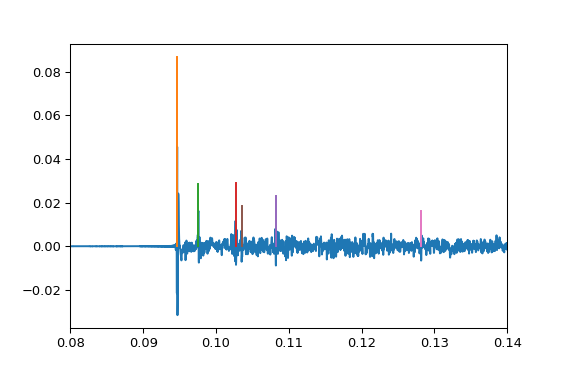

(0.08, 0.14)

In [160]:
nechoes = 6
echoes = find_echoes(ri_1,nechoes)
t = np.arange(len(ri_1))/fs
fig, ax = plt.subplots()
ax.plot(t,ri_1)
for n in range(nechoes):
    amp = np.sqrt(echoes[n,1])
    ax.plot([echoes[n,0],echoes[n,0]],[0,amp])
ax.set_xlim([0.08,0.14])    